In [1]:
import sys,os
sys.path.append("../")

import pandas as pd
import numpy as np
import pickle

from scipy.stats import entropy
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances  
from sklearn.metrics import mutual_info_score

import matplotlib.pyplot as plt
from IPython.display import HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import seaborn as sns




## Reading the change object and clustering.

In [2]:
article_name = "Truth"
change_object_dir =  "../data/change objects/"

change_object_file_name = f"{article_name}_vec.npz"
filename =  f"{article_name}_change.h5"

change_object_file = os.path.join(change_object_dir, filename)


change_vector_dir = "../data/change_vector_optimised/"
change_vec_filename = f"{article_name}_comp_vec.npz"
change_vector_file = os.path.join(change_vector_dir, change_vec_filename)

content_dir = "../data/content/"
len_file = article_name + "_rev_len.h5"
len_file_path = os.path.join(content_dir, len_file)


In [3]:
%%time
if os.path.exists(change_object_file):
    with pd.HDFStore(change_object_file, 'r') as store:
        change_object_dataframe = store.get("data")
else:
    print("file do not exist")
    
rev_len_df = pd.read_hdf(len_file_path, key = "rev_len")
vectors ={}
change_object_dataframe["edit_tokens"] = change_object_dataframe["ins_tokens"] + change_object_dataframe["del_tokens"]
with open(change_vector_file, "rb") as file:
    arrays_dict = np.load(file)
    
    vectors["clean_weighted_4"] = arrays_dict["4_clean_weighted"]
#     vectors["clean_notweighted_4"] = arrays_dict["4_clean_not_weighted"]
#     vectors["notclean_weighted_4"] = arrays_dict["4_notclean_weighted"]
#     vectors["notclean_notweighted_4"] = arrays_dict["4_notclean_not_weighted"]
    
    vectors["clean_weighted_10"] = arrays_dict["10_clean_weighted"]
#     vectors["clean_notweighted_10"] = arrays_dict["10_clean_not_weighted"]
#     vectors["notclean_weighted_10"] = arrays_dict["10_notclean_weighted"]
#     vectors["notclean_notweighted_10"] = arrays_dict["10_notclean_not_weighted"]
    
#     vectors["clean_weighted_30"] = arrays_dict["filtered_weighted_neighbour30_matrix"]
#     vectors["clean_notweighted_30"] = arrays_dict["filtered_not_weighted_neighbour30_matrix"]
#     vectors["notclean_weighted_30"] = arrays_dict[ "not_filtered_weighted_neighbour30_matrix"]
#     vectors["notclean_notweighted_30"] = arrays_dict["not_filtered_not_weighted_neighbour30_matrix"]



CPU times: user 1 s, sys: 1.05 s, total: 2.05 s
Wall time: 2.05 s


## Finding relative positions of change object

In [4]:
change_object_dataframe = change_object_dataframe.reset_index().set_index('from revision id')
change_object_dataframe = change_object_dataframe.join(rev_len_df.set_index("rev_id"))
change_object_dataframe.index.name = "from revision id"

change_object_dataframe["relative_position"] =(change_object_dataframe["left_neigh"]+1)/(change_object_dataframe["length"]).round(3)

change_object_dataframe = change_object_dataframe.reset_index().set_index(["from revision id","timestamp", "level_5"])
# rel_pos = change_object_dataframe["relative_position"]
# rel_pos_r = rel_pos.round(4)
# rel_pos_r.size
change_object_dataframe.shape

(31777, 18)

In [5]:
def gini(array):
    # Number of array elements:
    n = array.shape[0]
    index = np.arange(1, n+1)
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [6]:
def evaluate(change_object_dataframe, clusters, evaluation_df, column_names):
    
    change_object_dataframe["cluster"] = pd.Series(clusters, index= change_object_dataframe.index)
    
    stats_series = pd.Series(index=column_names)
    
    non_negative_cluster_mask = clusters != -1
    non_neg_cluster_df = change_object_dataframe.loc[non_negative_cluster_mask, :]

    stats_series["no_of_outliers"]  = np.count_nonzero(~non_negative_cluster_mask)
    stats_series["no_of_clusters"] = np.unique(clusters[non_negative_cluster_mask]).size

    rank_by_size = non_neg_cluster_df.groupby("cluster").size().sort_values(ascending=False)

    relative_postion_std = non_neg_cluster_df.groupby("cluster")["relative_position"].std()
#     stats_series["relative_position_std_max"] = relative_postion_std.max()
#     stats_series["relative_position_std_min"] = relative_postion_std.min()
#     stats_series["relative_position_std_median"] = relative_postion_std.median()
#     stats_series["relative_position_std_skewness"] = relative_postion_std.skew()
#     stats_series["relative_position_std_kurtosis"] = relative_postion_std.kurt()

    stats_series["relative_position_std_less_than_.1"] = np.count_nonzero(relative_postion_std <.1)
    

    size_stats = rank_by_size.describe()
    if rank_by_size.shape[0] > 1:
        stats_series["top2_ratio"] = rank_by_size.iloc[1]/rank_by_size.iloc[0]
    else:
        stats_series["top2_ratio"] = 0
    stats_series["max_cluster_size"] = size_stats["max"]
    stats_series["min_cluster_size"] = size_stats["min"]
    stats_series["mean_cluster_size"] = size_stats["mean"]
    stats_series["median_cluster_size"] = size_stats["50%"]
    stats_series["inter_quartile_range_cluster_size"] = size_stats["75%"] - size_stats["25%"]

    stats_series["variance_cluster_size"] = rank_by_size.var()
    stats_series["standard_deviation_cluster_size"] = size_stats["std"]
    stats_series["skewness_cluster_size"] = rank_by_size.skew()
    stats_series["kurtosis_cluster_size"] = rank_by_size.kurt()
    
    cluster_sizes = non_neg_cluster_df.groupby("cluster").size().values
    cluster_sizes = cluster_sizes / cluster_sizes.sum()
    
    token_entropy_clusters = non_neg_cluster_df.groupby("cluster")["edit_tokens"].apply(
        lambda token_tuples: entropy(pd.Series(
            [token for token_tuple in token_tuples.tolist() for token in token_tuple]
        ).value_counts().values))
    stats_series["token_entropy"] = (cluster_sizes * token_entropy_clusters).sum()
    
    position_entropy_clusters = non_neg_cluster_df.groupby("cluster")["relative_position"].apply(
        lambda x: entropy(x.value_counts().values))
    stats_series["position_entropy"] = (cluster_sizes * position_entropy_clusters).sum()

 
    stats_series["gini"] = gini(rank_by_size.values)
    
    change_object_dataframe  = change_object_dataframe.drop("cluster",axis=1)
    
    return stats_series

# Evaluation of DBSCAN


Following is the description of Pre evaluation metric 


### represents the noise in the tokens in the clusters. 
* __"token_entropy"__: Sum of Shanon entropies of cluster tokens weighted by cluster sizes. Weighting is done to give more weight to bigger clusters. 
As its easier to have smaller cluster with relatively less kind of data hence high shannon entropy

### These represent ability of DBSCAN to find clusters.
* "no_of_outliers": Total number of data points which were not put in any clusters by dbscan.
* "no_of_clusters": Total number of clusters found by the algorithm.

### These represents stability of clusters with respect to relative position of change object in its revision.
* __"position_entropy"__: Sum of Shanon entropies of relative position in a cluster weighted by cluster sizes. Weighting is done to give more weight to bigger clusters. As its easier to have smaller cluster with relatively less kind of data hence high shannon entropy.
* "relative_position_std_less_than_.1": Counts the clusters where relative position standard deviation is less thatn 0.1

### These represents  discriptive statistics representing distribution  of clusters sizes.
* "max_cluster_size": Gives size of points inside biggest clusters.
* "min_cluster_size": Gives size of points inside samllest clusters.
* "mean_cluster_size": Gives mean cluster size.
* "skewness_cluster_size": 
* "kurtosis_cluster_size":
* "median_cluster_size": Gives median cluster size.
* "inter_quartile_range_cluster_size": Gives inter quartile range of cluster size. i.e. Difference between 1st quartile and 3rd quartile. 
* "variance_cluster_size": Variance in cluster size values across all clusters.
* "standard_deviation_cluster_size": Square root of clusters. Easy to interpret as is direct representation of dispersion in distribution.

#### These Two represent distribution of cluster sizes
* "top2_ratio": Ratio of second biggest cluster size with the biggest cluster size
* "gini": Gini coeffecient of cluster size distribution among clusters.


---
---
__Shanon Entropy__ : Shanon's entropy formally $\displaystyle\sum_{i}p_i\log{p_i}$ where $p_i$ is probability of ith kind of data.
This value is zero when infromation is pure and it tends towards infinity as noise of type of data starts increasing.
Similar idea is used in decision tree to find pure classification.

__Total Entropy__: While calucalting total entropy we do not take oridinary sum because smaller clusters will tend to have less noise. 



In [7]:
change_object_dataframe["relative_position"] = (change_object_dataframe["relative_position"] - change_object_dataframe["relative_position"].mean())/change_object_dataframe["relative_position"].std()
dbscan_params =[
    { "eps": 0.5, "min_samples": 5 }, 
    { "eps": 1.0, "min_samples": 5 },
    { "eps": 1.5, "min_samples": 5 },
    { "eps": 2.0, "min_samples": 5 },
    { "eps": 2.5, "min_samples": 5 },
    { "eps": 3.0, "min_samples": 5 },
    { "eps": 3.5, "min_samples": 5 },
    { "eps": 4.0, "min_samples": 5 },
]

# vector_names = ["clean_weighted_4", "clean_weighted_10", "clean_weighted_30",
#                 "clean_notweighted_4", "clean_notweighted_10", "clean_notweighted_30",
#                 "notclean_weighted_4", "notclean_weighted_10", "notclean_weighted_30",
#                 "notclean_notweighted_4", "notclean_notweighted_10",  "notclean_notweighted_30"  
#                ]

vector_names = [ "clean_weighted_4", "clean_weighted_10", "clean_notweighted_4", "clean_weighted_30"]

column_names = ["top2_ratio","no_of_outliers", "no_of_clusters",

                "relative_position_std_less_than_.1",
                "max_cluster_size", "min_cluster_size", "mean_cluster_size",
                "skewness_cluster_size", "kurtosis_cluster_size",
                 "median_cluster_size",  "inter_quartile_range_cluster_size",
                "variance_cluster_size", "standard_deviation_cluster_size",
                "gini", "token_entropy", "position_entropy"]
idx = pd.MultiIndex.from_product([vector_names, 
                                  [ param["eps"] for param in dbscan_params]],
                             names=['types', 'eps'])
evaluation_df = pd.DataFrame(index=idx, columns=column_names)
# sns.distplot(change_object_dataframe["relative_position"])



In [ ]:
%%time
for cluster_by in vector_names:
#     distances = pairwise_distances(vectors[cluster_by])
    for dbscan_param in dbscan_params:
        clusters = DBSCAN(**dbscan_param).fit(vectors[cluster_by])
        evaluation_df.loc[(cluster_by,dbscan_param["eps"]),:] = evaluate(
            change_object_dataframe, clusters.labels_, evaluation_df, column_names)

In [ ]:
split_df = evaluation_df.reset_index()["types"].str.split("_", expand = True)[[0,1,2]]
split_df.index = evaluation_df.index
evaluation_df[["cleaned", "weighted", "neighbour_size"]] = split_df
# evaluation_df = evaluation_df.reset_index().set_index(["cleaned", "weighing", "neighbour"])
evaluation_df=evaluation_df.reset_index().set_index(["cleaned", "weighted", "neighbour_size","eps"])

In [ ]:
pre_evaluation_dir = "../data/pre_evaluation/"
file_name = f"{article_name}.csv"
full_file_path = os.path.join(pre_evaluation_dir, file_name)
evaluation_df.to_csv(full_file_path)
# for name in column_names:
#     file_name = f"{article_name}_{name}.csv"
#     full_file_path = os.path.join(pre_evaluation_dir, file_name)

In [22]:
display(evaluation_df[column_names[0]].unstack([-2,-1]))

neighbour_size              4                                           \
eps                       0.5       1.0       1.5       2.0        2.5   
cleaned weighted                                                         
clean   notweighted  0.216958  0.306733  0.306733   0.34298  0.0446658   
        weighted     0.216958  0.377805  0.433915  0.583578  0.0308453   

neighbour_size                                                10            \
eps                        3.0         3.5         4.0       0.5       1.0   
cleaned weighted                                                             
clean   notweighted  0.0361478   0.0320282  0.00522971       NaN       NaN   
        weighted     0.0366455  0.00736864  0.00536332  0.481752  0.562044   

neighbour_size          ...                                     30        \
eps                     ...              3.5         4.0       0.5   1.0   
cleaned weighted        ...                                                
clean   notweighted     ...              NaN         NaN       NaN   NaN   
        weighted        ...       0.00270168  0.00145849  0.835821  0.85   

neighbour_size                                                      \
eps                       1.5         2.0         2.5          3.0   
cleaned weighted                                                     
clean   notweighted       NaN         NaN         NaN          NaN   
        weighted     0.023814  0.00680979  0.00162448  0.000666564   

neighbour_size                                 
eps                          3.5          4.0  
cleaned weighted                               
clean   notweighted          NaN          NaN  
        weighted     0.000663502  0.000662623  

[2 rows x 24 columns]

In [23]:

display(evaluation_df["skewness_cluster_size"].unstack([-2,-1]))

neighbour_size             4                                               \
eps                      0.5      1.0      1.5      2.0      2.5      3.0   
cleaned weighted                                                            
clean   notweighted  17.6701  16.1741   16.542  18.9195  19.8673  15.4242   
        weighted     17.5722  16.0386  14.2504    17.26  21.3035  17.2738   

neighbour_size                              10            ...              \
eps                      3.5      4.0      0.5      1.0   ...         3.5   
cleaned weighted                                          ...               
clean   notweighted  9.93333  6.55718      NaN      NaN   ...         NaN   
        weighted     12.5667  7.68071  7.04719  6.03444   ...     6.16433   

neighbour_size                     30                                      \
eps                      4.0      0.5      1.0      1.5      2.0      2.5   
cleaned weighted                                                            
clean   notweighted      NaN      NaN      NaN      NaN      NaN      NaN   
        weighted     3.74165  3.71887  5.49261  20.1495  10.2457  6.08273   

neighbour_size                              
eps                      3.0  3.5      4.0  
cleaned weighted                            
clean   notweighted      NaN  NaN      NaN  
        weighted     2.82843    2  1.73205  

[2 rows x 24 columns]

In [24]:
display(evaluation_df["max_cluster_size"].unstack([-2,-1]))

neighbour_size         4                                              10       \
eps                  0.5  1.0  1.5   2.0   2.5    3.0    3.5    4.0  0.5  1.0   
cleaned weighted                                                                
clean   notweighted  802  802  802  1866  6627  11287  15018  17783  NaN  NaN   
        weighted     802  802  802  1705  5868   9933  14521  17340  137  137   

neighbour_size       ...                   30                            \
eps                  ...      3.5    4.0  0.5  1.0    1.5    2.0    2.5   
cleaned weighted     ...                                                  
clean   notweighted  ...      NaN    NaN  NaN  NaN    NaN    NaN    NaN   
        weighted     ...    18507  19198   67  200  10582  17328  19083   

neighbour_size                            
eps                    3.0    3.5    4.0  
cleaned weighted                          
clean   notweighted    NaN    NaN    NaN  
        weighted     19503  19593  19619  

[2 rows x 24 columns]

In [25]:
evaluation_df["token_entropy"].unstack([-2,-1])

neighbour_size             4                                               \
eps                      0.5      1.0      1.5      2.0      2.5      3.0   
cleaned weighted                                                            
clean   notweighted  3.90579  3.99667  3.96891  4.28754   5.1184  5.67892   
        weighted     3.92103  3.92916  3.97553  4.27134  4.88352  5.49663   

neighbour_size                              10            ...              \
eps                      3.5      4.0      0.5      1.0   ...         3.5   
cleaned weighted                                          ...               
clean   notweighted  5.99509  6.11738      NaN      NaN   ...         NaN   
        weighted     5.88845   6.0902  3.15116  3.14245   ...     6.14656   

neighbour_size                     30                                      \
eps                      4.0      0.5      1.0      1.5      2.0      2.5   
cleaned weighted                                                            
clean   notweighted      NaN      NaN      NaN      NaN      NaN      NaN   
        weighted     6.17984  2.98537  3.59737  5.38991  6.05428  6.15476   

neighbour_size                                  
eps                      3.0      3.5      4.0  
cleaned weighted                                
clean   notweighted      NaN      NaN      NaN  
        weighted     6.19501  6.19998  6.20108  

[2 rows x 24 columns]

In [61]:
# evaluation_df.loc["clean","weighted",:,[0.5,1.0]].head(10)
evaluation_df[column_names]

top2_ratio no_of_outliers  \
cleaned weighted    neighbour_size eps                               
clean   weighted    4              0.5     0.216958          14025   
                                   1.0     0.377805          13124   
                                   1.5     0.433915          12071   
                                   2.0     0.583578          10641   
                                   2.5    0.0308453           8597   
                                   3.0    0.0366455           5812   
                                   3.5   0.00736864           3245   
                                   4.0   0.00536332           1610   
                    10             0.5     0.481752          15871   
                                   1.0     0.562044          14464   
                                   1.5     0.656934          12498   
                                   2.0    0.0814044           9101   
                                   2.5    0.0415183           4830   
                                   3.0   0.00364462           2088   
                                   3.5   0.00270168            788   
                                   4.0   0.00145849            299   
        notweighted 4              0.5     0.216958          14010   
                                   1.0     0.306733          13764   
                                   1.5     0.306733          13064   
                                   2.0      0.34298          11659   
                                   2.5    0.0446658           8648   
                                   3.0    0.0361478           5360   
                                   3.5    0.0320282           2855   
                                   4.0   0.00522971           1401   
        weighted    30             0.5     0.835821          14957   
                                   1.0         0.85           9684   
                                   1.5     0.023814           4418   
                                   2.0   0.00680979           1233   
                                   2.5   0.00162448            251   
                                   3.0  0.000666564             85   
                                   3.5  0.000663502             20   
                                   4.0  0.000662623              3   

                                       no_of_clusters  \
cleaned weighted    neighbour_size eps                  
clean   weighted    4              0.5            424   
                                   1.0            484   
                                   1.5            532   
                                   2.0            543   
                                   2.5            457   
                                   3.0            300   
                                   3.5            158   
                                   4.0             59   
                    10             0.5            398   
                                   1.0            513   
                                   1.5            656   
                                   2.0            592   
                                   2.5            286   
                                   3.0             90   
                                   3.5             38   
                                   4.0             14   
        notweighted 4              0.5            429   
                                   1.0            433   
                                   1.5            481   
                                   2.0            496   
                                   2.5            398   
                                   3.0            239   
                                   3.5             99   
                                   4.0             43   
        weighted    30             0.5            507   
                                   1.0            759   
                                   1.5            407   
       

ValueError: color kwarg must have one color per dataset

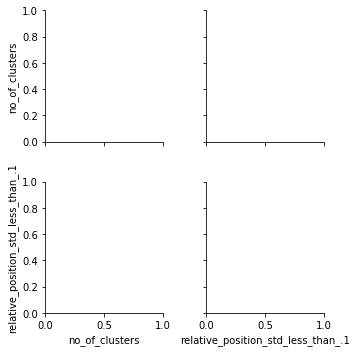

In [55]:
# sns.pairplot(evaluation_df.loc["clean","weighted", :,:][column_names[2:4]])

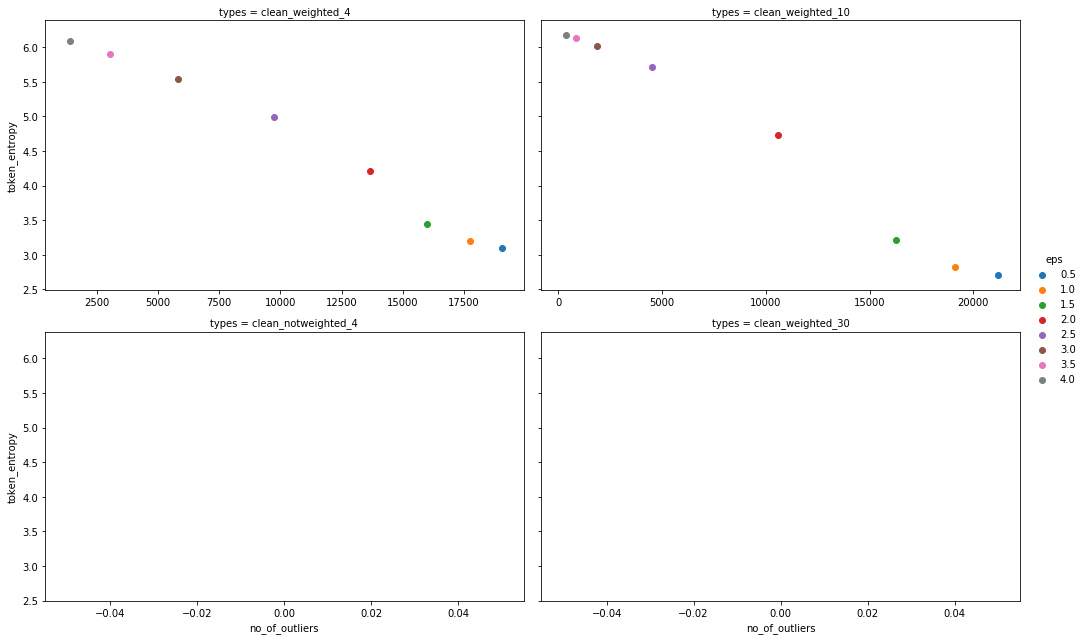

In [11]:
g = sns.FacetGrid(evaluation_df.reset_index(), col="types", col_wrap=2, sharex=False, sharey=True, aspect=1.6, height=4.5, despine=False, hue="eps")
g = (g.map(plt.scatter,  "no_of_outliers", "token_entropy").add_legend())
# plt.yscale("log")

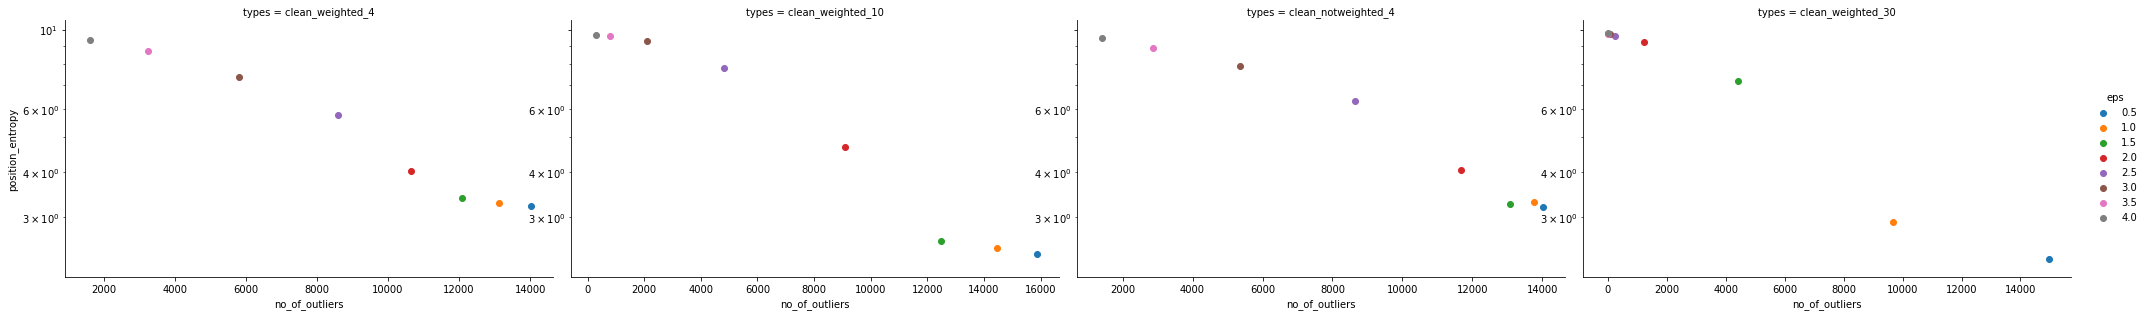

In [87]:
g = sns.FacetGrid(evaluation_df.reset_index(), col="types", col_wrap=4, sharex=False, sharey=True, aspect=1.6, height=4.5, despine=True, hue="eps")
g = (g.map(plt.scatter,  "no_of_outliers", "position_entropy").add_legend())
plt.yscale("log")

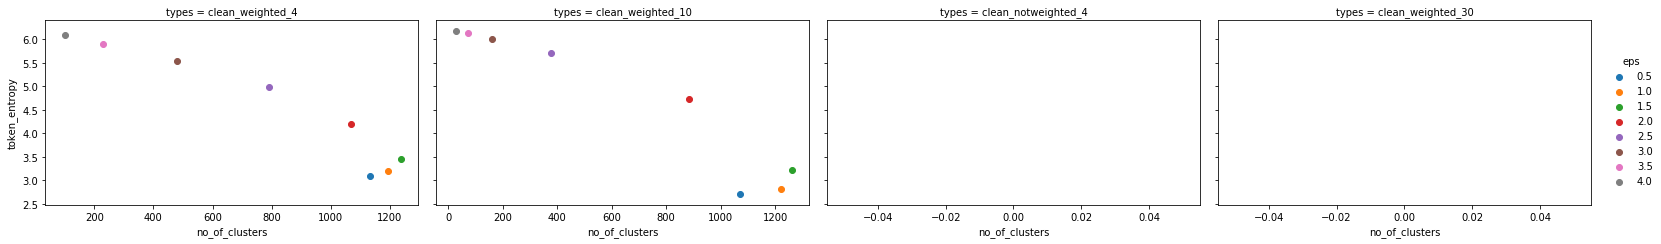

In [12]:
g = sns.FacetGrid(evaluation_df.reset_index(), col="types", col_wrap=4, sharex=False, sharey=True, aspect=1.6, height=3.5, despine=False, hue="eps")
g = (g.map(plt.scatter,  "no_of_clusters", "token_entropy").add_legend())

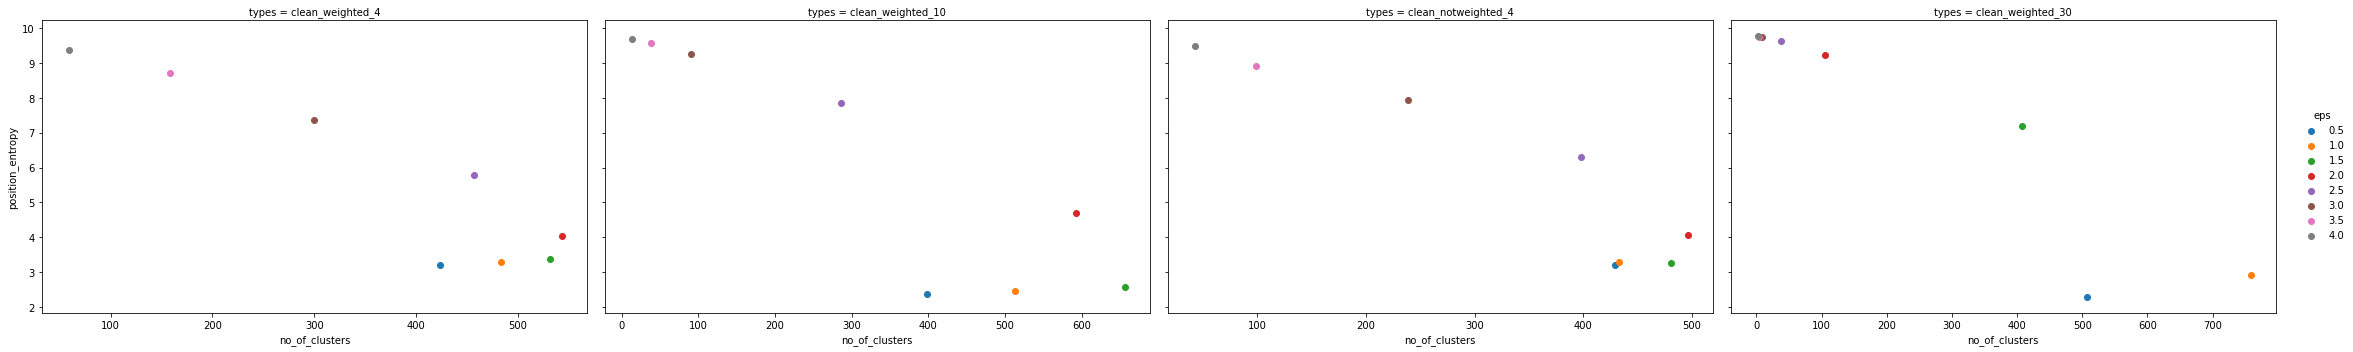

In [80]:
g = sns.FacetGrid(evaluation_df.reset_index(), col="types", col_wrap=4, sharex=False, sharey=True, aspect=1.6, height=5, despine=False, hue="eps")
g = (g.map(plt.scatter,  "no_of_clusters", "position_entropy").add_legend())

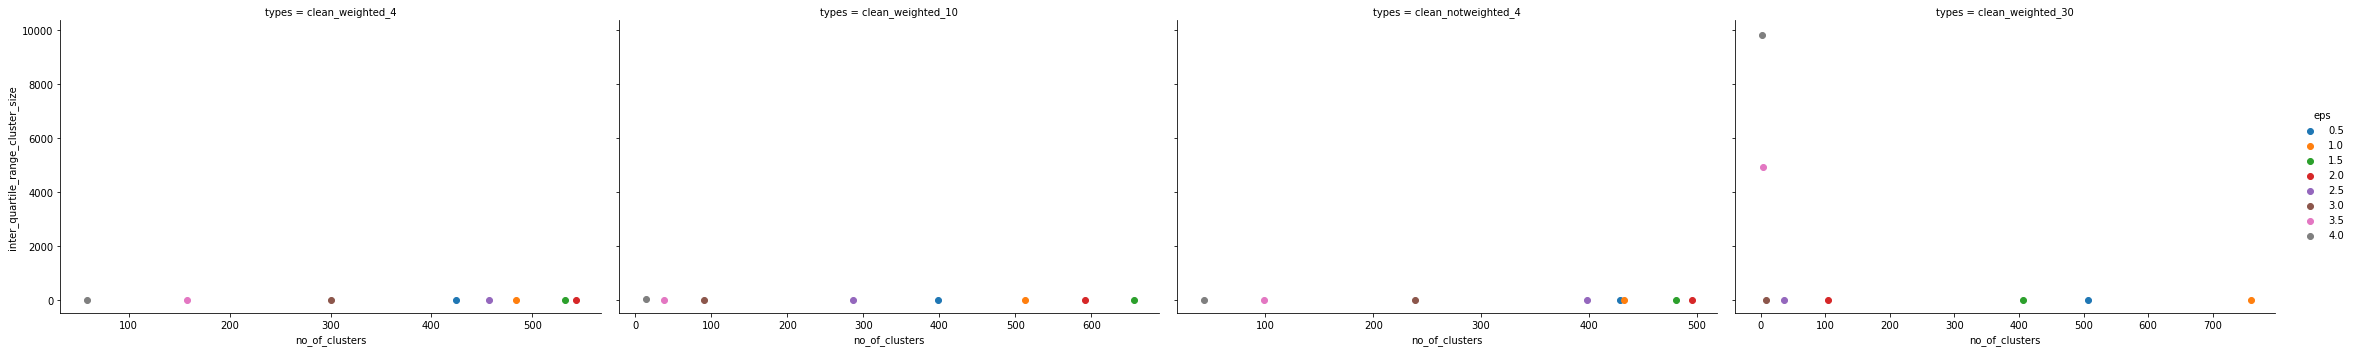

In [89]:
g = sns.FacetGrid(evaluation_df.reset_index(), col="types", col_wrap=4, sharex=False, sharey=True, aspect=1.6, height=5,hue="eps")
g = (g.map(plt.scatter, "no_of_clusters", "inter_quartile_range_cluster_size").add_legend())
# plt.yscale("log")

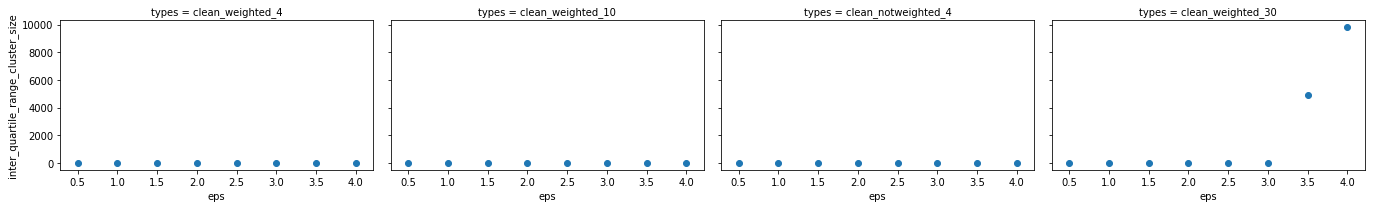

In [85]:
g = sns.FacetGrid(evaluation_df.reset_index(), col="types", col_wrap=4, sharex=True, sharey=True, aspect=1.6, despine=False)
g = g.map(plt.scatter, "eps", "inter_quartile_range_cluster_size")

In [ ]:

g = sns.FacetGrid(evaluation_df.reset_index(), col="types",col_wrap=3, sharex=True, sharey=True, aspect=1.6, despine=False)
g = g.map(plt.scatter,  "eps", "standard_deviation_cluster_size")

In [ ]:
g = sns.FacetGrid(evaluation_df.reset_index(), col="types", col_wrap=6, sharex=False, sharey=False, aspect=1.6, despine=False)
g = g.map(plt.scatter,  "eps", "relative_position_std_less_than_.1")

In [ ]:
g = sns.FacetGrid(evaluation_df.reset_index(), col="types", col_wrap=6, sharex=False, sharey=False, aspect=1.6, despine=False)
g = g.map(plt.scatter,  "eps", "top2_ratio")